In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap

import networkx as nx

from minimal.imaging import blit_rooms
from minimal.layout import LayoutGraph, NodeType
from minimal.gen import generate_plan, PlanMasks
from minimal import sample_graphs
from minimal.rooms import RoomAreas, extract_rooms, create_orientation_mask
from minimal.walls import find_walls, intersect_rooms, join_wall_corners, _conv_mask

%matplotlib inline

In [3]:
cmapr = ListedColormap(['white', *plt.get_cmap('tab10').colors])
cmapw = ListedColormap(['white', 'black', *plt.get_cmap('tab10').colors])

In [79]:
%%time
pm = PlanMasks.create_from_state(torch.load("data/plan_masks_03.pth"))
rooms = extract_rooms(pm)

CPU times: user 1.37 s, sys: 2.21 ms, total: 1.37 s
Wall time: 1.37 s


In [80]:
rect_mask = sum(room.to_mask() * (i + 1) for i, room in enumerate(rooms))

In [97]:
walls_mask, orient_mask, inner_mask = intersect_rooms(rooms)

In [98]:
walls_mask, orient_mask = join_wall_corners(walls_mask, orient_mask, inner_mask)

tensor(True)


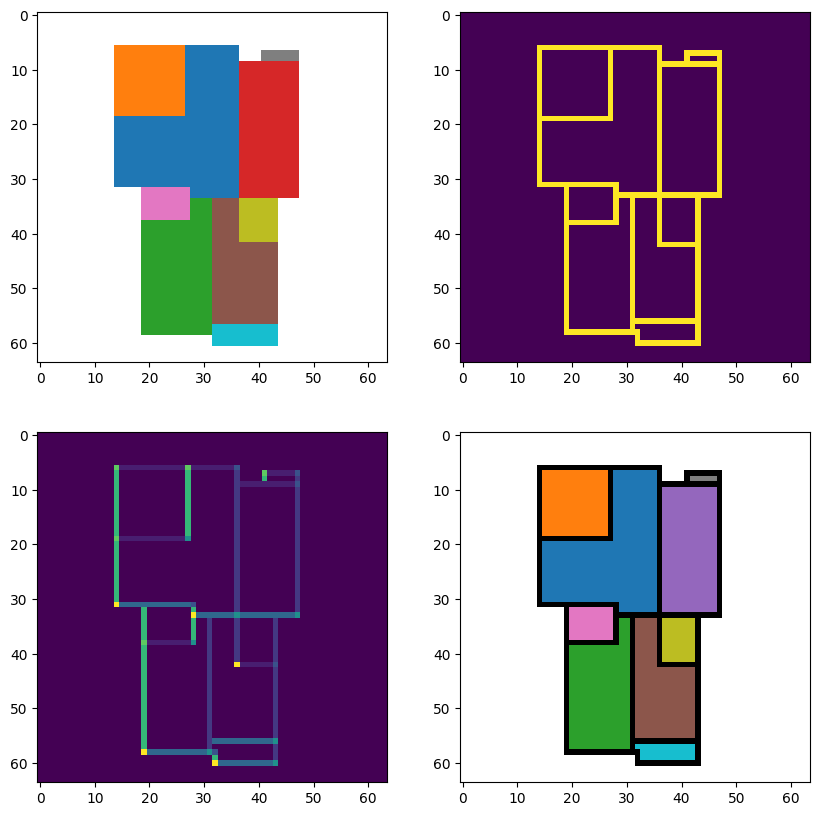

In [109]:
print(torch.all(walls_mask * inner_mask == walls_mask))

plt.figure(figsize=(10,10))

plt.subplot(221)
plt.imshow(rect_mask, cmap=cmapr)

plt.subplot(222)
plt.imshow(walls_mask)

plt.subplot(223)
plt.imshow(orient_mask)

plt.subplot(224)
rooms_with_walls = sum(room.to_mask() * (i + 2) for i, room in enumerate(rooms))
rooms_with_walls[torch.where(walls_mask == 1)] = 1
plt.imshow(rooms_with_walls, cmap=cmapw)